## Predicting Wildfires Using Machine Learning Models

In [2]:
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

from sklearn import datasets
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.impute import KNNImputer

# For modeling functions
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
# from sklearn.pipeline import make_pipeline
import xgboost as XGB
from keras.models import Sequential
from keras.layers import Dense


import statistics as stat

### 1. Initial Informations

In [4]:
fire_original = pd.read_csv('dataset.csv')

In [5]:
df = fire_original.copy()
df['IG_DATE'] = pd.to_datetime(df['IG_DATE'])
df.shape

(29533, 25)

In [6]:
df.head()

,X,Y,OBJECTID,FIRE_ID,ASMNT_TYPE,PRE_ID,POST_ID,NODATA_THRESHOLD,LOW_THRESHOLD,MODERATE_THRESHOLD,...,GREENNESS_THRESHOLD,IG_DATE,ACRES,IRWINID,MAP_ID,MAP_PROG,PERIM_ID,DNBR_OFFST,DNBR_STDDV,COMMENTS
0,-117.637839,33.710768,347841,CA3370911761819840126,Extended (SS),NaN,504003719840623,9999,150,-70,...,9999,1984-01-26 00:00:00+00:00,1266,NaN,10005362,MTBS,504003719840323,-9999,-9999,NaN
1,-94.655528,36.981695,347842,OK3698209465619840221,Initial (SS),NaN,502603419840418,9999,-50,-147,...,9999,1984-02-21 00:00:00+00:00,1048,NaN,4539,MTBS,NaN,-9999,-9999,NaN
2,-98.406773,30.374134,347843,TX3028409841719840226,Initial (SS),NaN,502703919840409,9999,100,-9999,...,9999,1984-02-26 00:00:00+00:00,3696,NaN,10003829,MTBS,NaN,-9999,-9999,NaN
3,-120.187609,36.073892,347844,CA3607412018819840329,Initial (SS),NaN,504203519840707,9999,-65,-280,...,9999,1984-03-29 00:00:00+00:00,1462,NaN,4557,MTBS,NaN,-9999,-9999,Single scene assessment
4,-102.751647,36.366836,347845,TX3635010276719840329,Initial (SS),NaN,503103519840608,9999,200,-9999,...,9999,1984-03-29 00:00:00+00:00,1110,NaN,10003855,MTBS,NaN,-9999,-9999,NaN


In [7]:
df.tail()

,X,Y,OBJECTID,FIRE_ID,ASMNT_TYPE,PRE_ID,POST_ID,NODATA_THRESHOLD,LOW_THRESHOLD,MODERATE_THRESHOLD,...,GREENNESS_THRESHOLD,IG_DATE,ACRES,IRWINID,MAP_ID,MAP_PROG,PERIM_ID,DNBR_OFFST,DNBR_STDDV,COMMENTS
29528,-112.852162,41.118485,377369,UT4113611287920210330,Initial,B12TUL20210316_30m,A12TUL20210410_30m,-970,50,9999,...,-150,2021-03-30 00:00:00+00:00,5879,1A6EF06F-0508-42FE-B365-85850E42EBCC,10021889,MTBS,NaN,21,15,NaN
29529,-81.453381,37.000647,377370,VA3699808145920210420,Initial,B17SMA20210406_30m,B17SMA20210426_30m,-970,15,9999,...,-150,2021-04-20 00:00:00+00:00,1460,NaN,10021929,MTBS,NaN,-41,11,NaN
29530,-117.179173,46.354268,377371,WA4637511716520210707,Initial,A11TMM20210705_30m,B11TMM20210713_30m,-970,45,9999,...,-150,2021-07-07 00:00:00+00:00,8864,236951C4-0149-4523-AE60-6AF68FD053D9,10021631,MTBS,NaN,-7,13,NaN
29531,-117.199507,46.481960,377372,WA4649011720020210722,Initial,A11TMM20200829_30m,B11TMM20210819_30m,-970,30,380,...,-150,2021-07-22 00:00:00+00:00,2758,E34E42E3-4F4C-4634-A37B-986191EE9F77,10021620,MTBS,NaN,-20,38,NaN
29532,-79.754360,38.387034,377373,WV3837407976020210404,Initial,A17SPC20210329_30m,B17SPC20210426_30m,-970,55,9999,...,-150,2021-04-04 00:00:00+00:00,711,67981B9B-9F8E-439B-83F6-ED1E4A40F860,10022134,MTBS,NaN,15,33,NaN


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29533 entries, 0 to 29532
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   X                    29533 non-null  float64            
 1   Y                    29533 non-null  float64            
 2   OBJECTID             29533 non-null  int64              
 3   FIRE_ID              29533 non-null  object             
 4   ASMNT_TYPE           29533 non-null  object             
 5   PRE_ID               20349 non-null  object             
 6   POST_ID              29533 non-null  object             
 7   NODATA_THRESHOLD     29533 non-null  int64              
 8   LOW_THRESHOLD        29533 non-null  int64              
 9   MODERATE_THRESHOLD   29533 non-null  int64              
 10  HIGH_THRESHOLD       29533 non-null  int64              
 11  LATITUDE             29533 non-null  float64            
 12  LONGITUDE         

Initial Unnecessary feature drop

In [9]:
df.drop(columns=['COMMENTS'], axis = 1, inplace=True)

### 1.1 Dealing with NA/NAN values

In [10]:
print(df.isnull().sum())

X                          0
Y                          0
OBJECTID                   0
FIRE_ID                    0
ASMNT_TYPE                 0
PRE_ID                  9184
POST_ID                    0
NODATA_THRESHOLD           0
LOW_THRESHOLD              0
MODERATE_THRESHOLD         0
HIGH_THRESHOLD             0
LATITUDE                   0
LONGITUDE                  0
FIRE_TYPE                  0
FIRE_NAME                  0
GREENNESS_THRESHOLD        0
IG_DATE                    0
ACRES                      0
IRWINID                25737
MAP_ID                     0
MAP_PROG                   0
PERIM_ID               26698
DNBR_OFFST                 0
DNBR_STDDV                 0
dtype: int64


<AxesSubplot: >

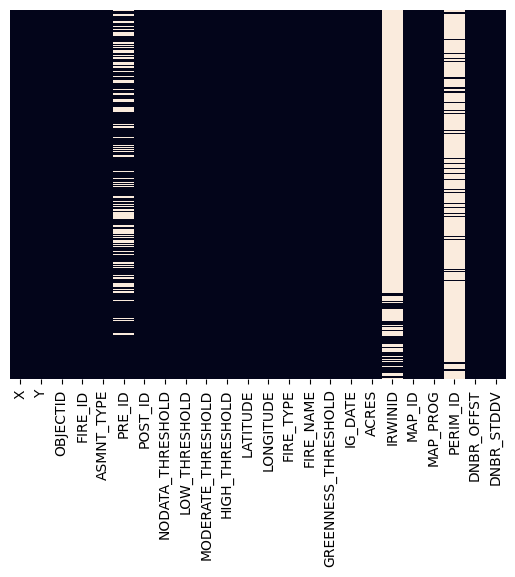

In [11]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False)

In [12]:
missing_fire = [col for col in df.columns if df[col].isnull().any()]
total_missing_fire = pd.DataFrame(df[missing_fire].isnull().sum(), columns = ['Missing Values'])
percentage_missing_fire = ((total_missing_fire['Missing Values'] * 100) / df.shape[0]).round(2)

print(f"Columns with missing values: {missing_fire}")
print(f"Percentage missing values: \n{percentage_missing_fire}")

Columns with missing values: ['PRE_ID', 'IRWINID', 'PERIM_ID']
Percentage missing values: 
PRE_ID      31.10
IRWINID     87.15
PERIM_ID    90.40
Name: Missing Values, dtype: float64


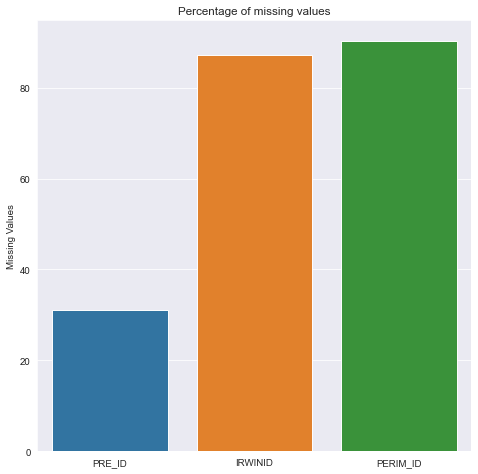

In [13]:
plt.figure(figsize = (8,8), dpi = 70)
sns.set_style('darkgrid')
sns.barplot(x = total_missing_fire.index, y = percentage_missing_fire, data = total_missing_fire)
plt.title('Percentage of missing values')
plt.show()

#### Smoothing the dataset

In [14]:
df['PRE_ID'] = df['PRE_ID'].fillna(df['PRE_ID'].mode()[0])
df['IRWINID'] = df['IRWINID'].fillna(df['IRWINID'].mode()[0])
df['PERIM_ID'] = df['PERIM_ID'].fillna(df['PERIM_ID'].mode()[0])

In [15]:
df.isnull().sum()

X                      0
Y                      0
OBJECTID               0
FIRE_ID                0
ASMNT_TYPE             0
PRE_ID                 0
POST_ID                0
NODATA_THRESHOLD       0
LOW_THRESHOLD          0
MODERATE_THRESHOLD     0
HIGH_THRESHOLD         0
LATITUDE               0
LONGITUDE              0
FIRE_TYPE              0
FIRE_NAME              0
GREENNESS_THRESHOLD    0
IG_DATE                0
ACRES                  0
IRWINID                0
MAP_ID                 0
MAP_PROG               0
PERIM_ID               0
DNBR_OFFST             0
DNBR_STDDV             0
dtype: int64

### 1.3 Dropping Unnecessary values

In [16]:
# ID columns to drop
drop_store = ['OBJECTID','FIRE_ID', 'PRE_ID', 'POST_ID', 'FIRE_NAME', 'IRWINID', 'MAP_ID', 'MAP_PROG', 'PERIM_ID']

# Drop ID columns in test and save it for future prediction
Test_ID = df['OBJECTID'].tolist() #used to convert the data elements of an array into a list.

df.drop(columns = drop_store, axis = 1, inplace = True)

df.shape

(29533, 15)

### 2. Data Exploration

In [17]:
(df.corr()**2)["ACRES"].sort_values(ascending = False)[:28]

ACRES                  1.000000
X                      0.049846
LONGITUDE              0.049837
Y                      0.043143
LATITUDE               0.043140
NODATA_THRESHOLD       0.008479
GREENNESS_THRESHOLD    0.008470
DNBR_OFFST             0.008335
DNBR_STDDV             0.000199
HIGH_THRESHOLD         0.000101
LOW_THRESHOLD          0.000093
MODERATE_THRESHOLD     0.000092
Name: ACRES, dtype: float64

#### Standardizing Data

In [18]:
df["ACRES"] = np.log1p(df["ACRES"])

In [19]:
def plotting_chart(df, feature):
    import matplotlib.gridspec as gridspec
    from scipy import stats
    import matplotlib.style as style
    style.use('fivethirtyeight')
    
    ## Creating customized chart
    fig = plt.figure(constrained_layout = True, figsize = (12, 8))
    ## Grid of 3 cols and 3 rows
    grid = gridspec.GridSpec(ncols = 3, nrows = 3, figure = fig)
    
    ## Customized histogram grid
    ax1 = fig.add_subplot(grid[0, :2])
    ax1.set_title('Histogram')
    # plot histogram
    sns.distplot(df.loc[:,feature], norm_hist = True, ax = ax1)
    
    
    
    ## Customized QQ_plot
    ax2 = fig.add_subplot(grid[1, :2])
    ax2.set_title('QQ_plot')
    # plot histogram
    stats.probplot(df.loc[:,feature], plot = ax2)
    
    ## Customized boxplot
    ax3 = fig.add_subplot(grid[:, 2])
    ax3.set_title('Box Plot')
    sns.boxplot(df.loc[:, feature], orient = 'v', ax = ax3)

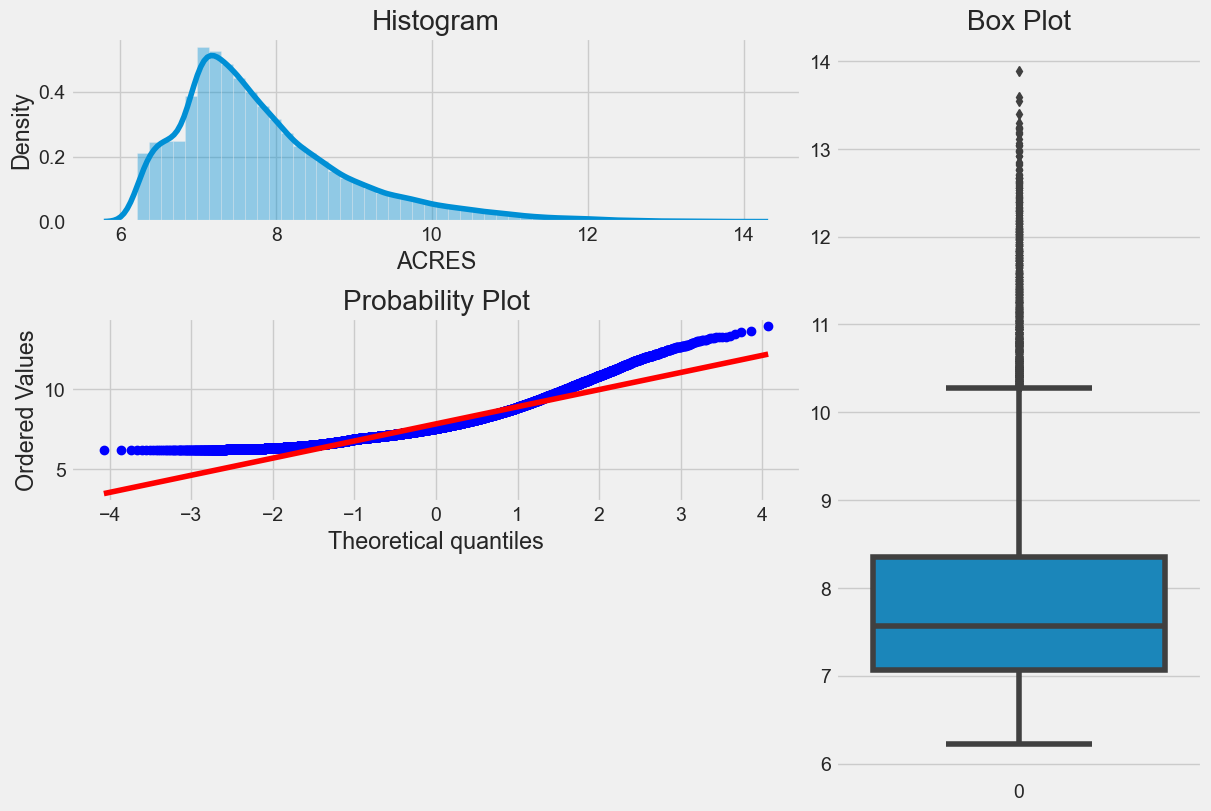

In [20]:
plotting_chart(df, 'ACRES')

### 3. Catagorical Data

In [21]:
fire_categoric = [col for col in df.columns if df[col].dtypes == 'object']
print(f"Categorical Features:\n{fire_categoric}")
print(f"\nTotal Categirical Features: {len(fire_categoric)}")

Categorical Features:
['ASMNT_TYPE', 'FIRE_TYPE']

Total Categirical Features: 2


In [22]:
df.describe(include='all')

,X,Y,ASMNT_TYPE,NODATA_THRESHOLD,LOW_THRESHOLD,MODERATE_THRESHOLD,HIGH_THRESHOLD,LATITUDE,LONGITUDE,FIRE_TYPE,GREENNESS_THRESHOLD,IG_DATE,ACRES,DNBR_OFFST,DNBR_STDDV
count,29533.000000,29533.000000,29533,29533.000000,29533.000000,29533.000000,29533.000000,29533.000000,29533.000000,29533,29533.000000,29533,29533.000000,29533.000000,29533.000000
unique,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,8466,NaN,NaN,NaN
top,NaN,NaN,Initial,NaN,NaN,NaN,NaN,NaN,NaN,Wildfire,NaN,2011-05-06 00:00:00+00:00,NaN,NaN,NaN
freq,NaN,NaN,14819,NaN,NaN,NaN,NaN,NaN,NaN,15593,NaN,198,NaN,NaN,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1984-01-26 00:00:00+00:00,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-12-15 00:00:00+00:00,NaN,NaN,NaN
mean,-100.969463,37.354464,NaN,2461.505807,13.947516,-76.532828,943.094335,37.354393,-100.969011,NaN,3023.249280,NaN,7.832861,-3089.105780,-7354.202214
std,17.822558,8.308088,NaN,5085.844792,1155.174561,6576.667457,8048.324642,8.308229,17.822535,NaN,4706.843424,NaN,1.116623,4622.880005,4416.357171
min,-166.091133,17.956564,NaN,-1500.000000,-9999.000000,-9999.000000,-9999.000000,17.957000,-166.067000,NaN,-650.000000,NaN,6.216606,-9999.000000,-9999.000000
25%,-113.940478,31.148959,NaN,-970.000000,45.000000,-139.000000,-9999.000000,31.148000,-113.939000,NaN,-150.000000,NaN,7.066467,-9999.000000,-9999.000000


#### Replacing unique catagorical data with numeric value

In [23]:
df['ASMNT_TYPE'].value_counts()

Initial          14819
Initial (SS)      9105
Extended          5475
Extended (SS)      134
Name: ASMNT_TYPE, dtype: int64

In [24]:
df['FIRE_TYPE'].value_counts()

Wildfire             15593
Prescribed Fire       7427
Unknown               6302
Wildland Fire Use      211
Name: FIRE_TYPE, dtype: int64

In [25]:
# replacing values for ASMNT_TYPE
df['ASMNT_TYPE'].replace(['Initial', 'Initial (SS)', 'Extended', 'Extended (SS)'], [0, 1, 2, 3], inplace=True)
# replacing values for FIRE_TYPE
df['FIRE_TYPE'].replace(['Wildfire', 'Prescribed Fire', 'Unknown', 'Wildland Fire Use'], [0, 1, 2, 3], inplace=True)


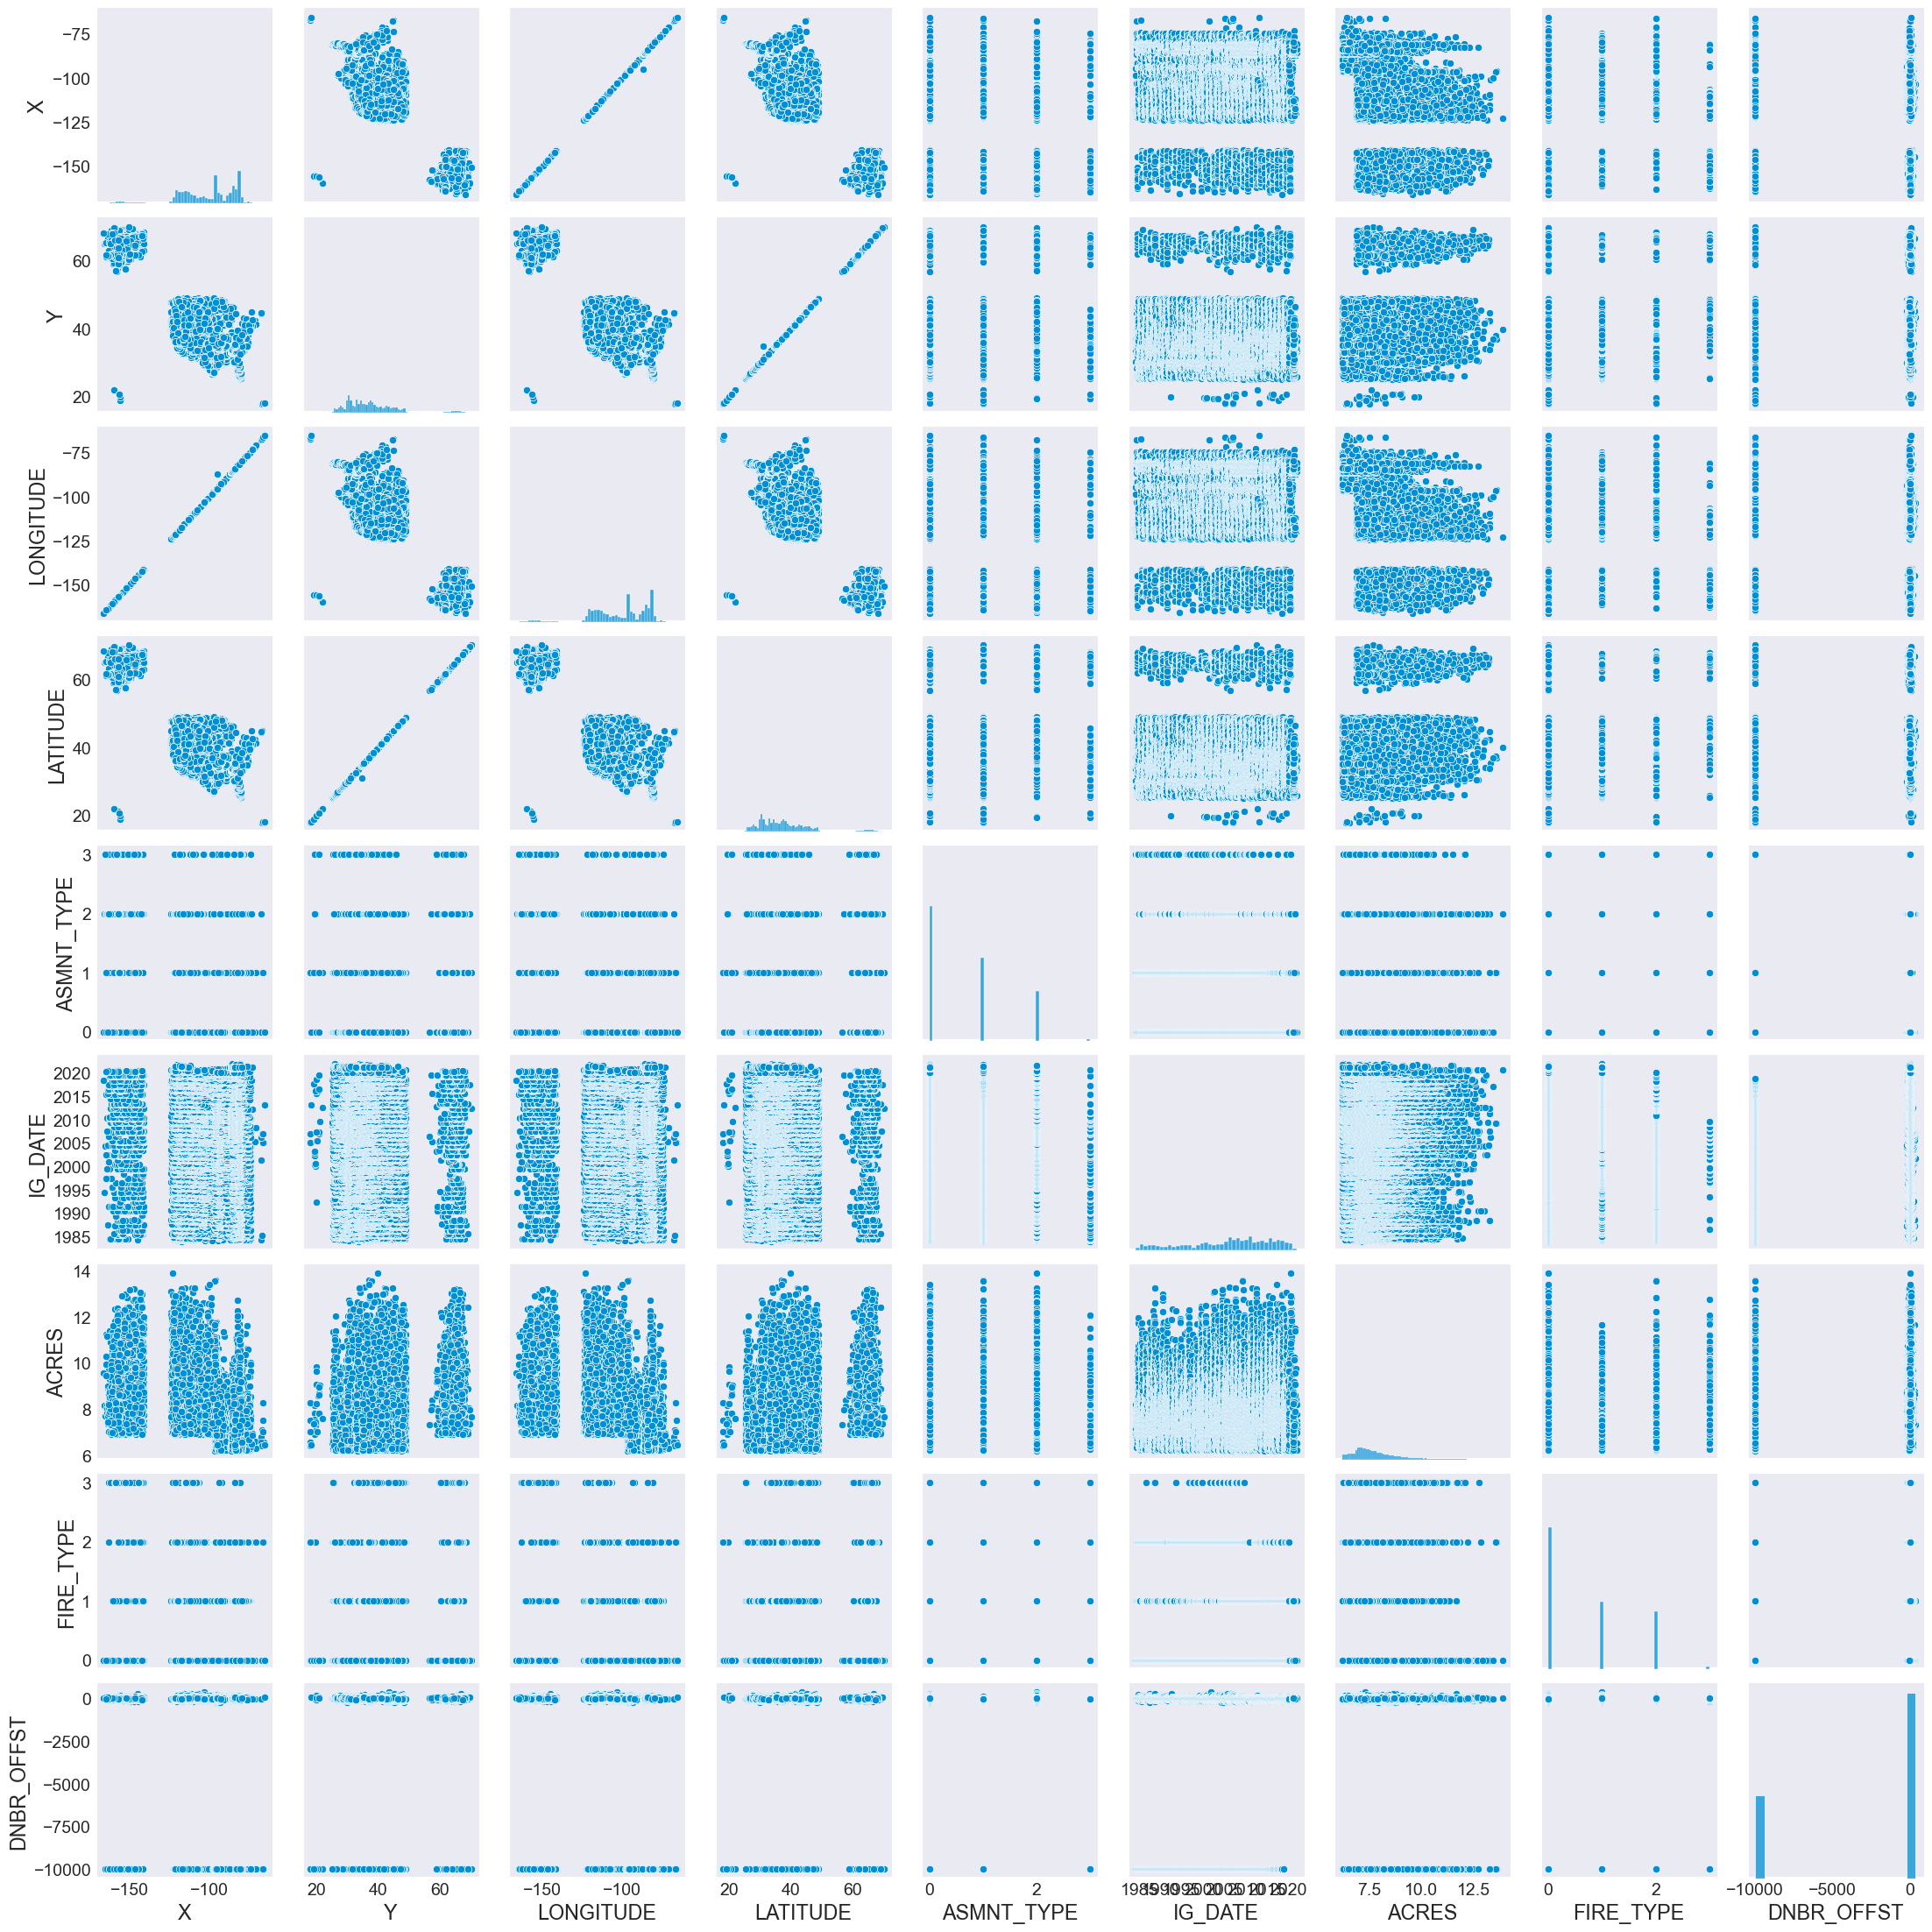

In [26]:
sns.set_style('dark')
sns.pairplot(df, hue=None, vars=['X', 'Y', 'LONGITUDE', 'LATITUDE', 'ASMNT_TYPE', 'IG_DATE', 'ACRES', 'FIRE_TYPE', 'DNBR_OFFST'])

#### Histogram plot of cleaned data

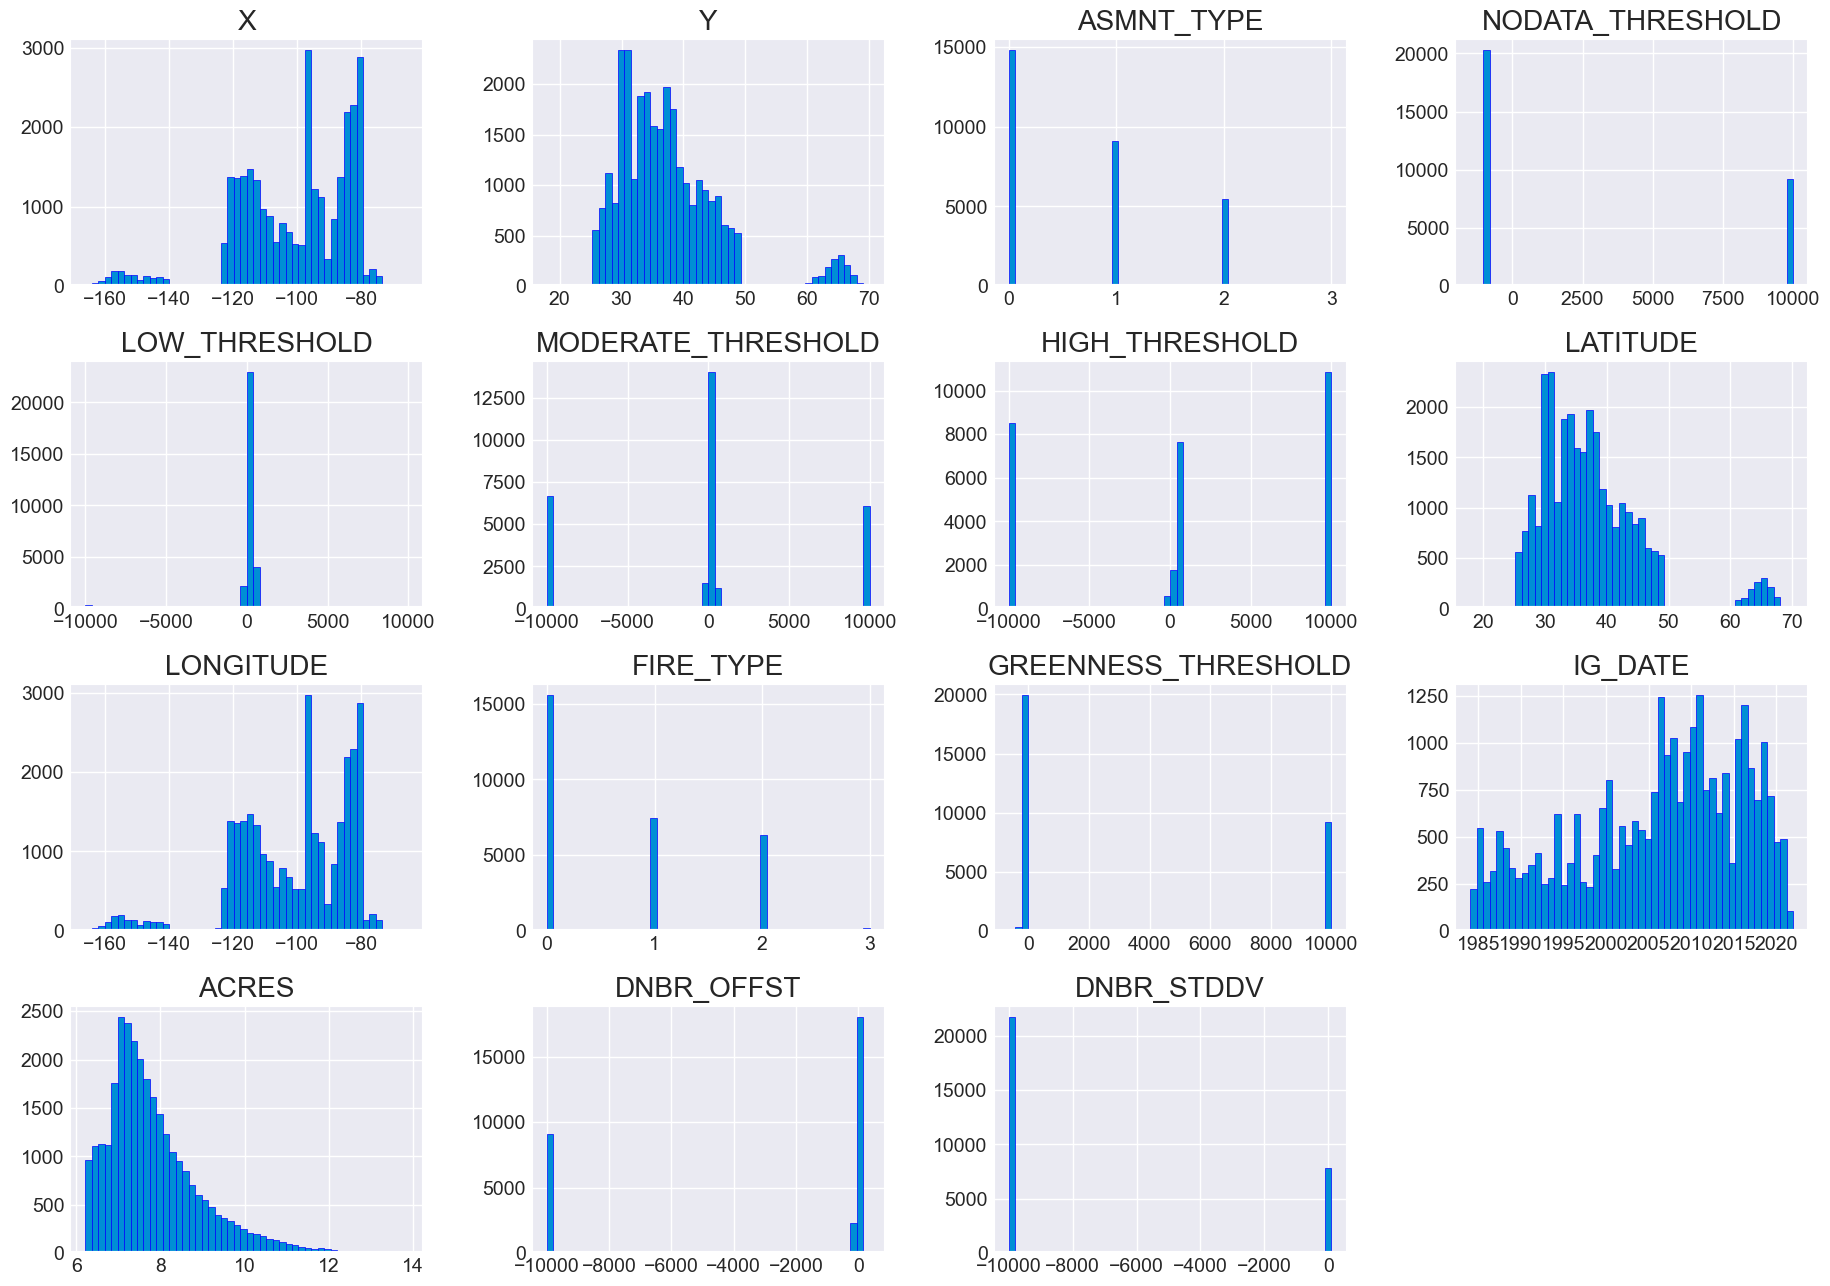

In [27]:
df.hist(bins=50, figsize=(20,15), ec = 'b')
plt.show()

### 4. Correlation Matrix

<AxesSubplot: >

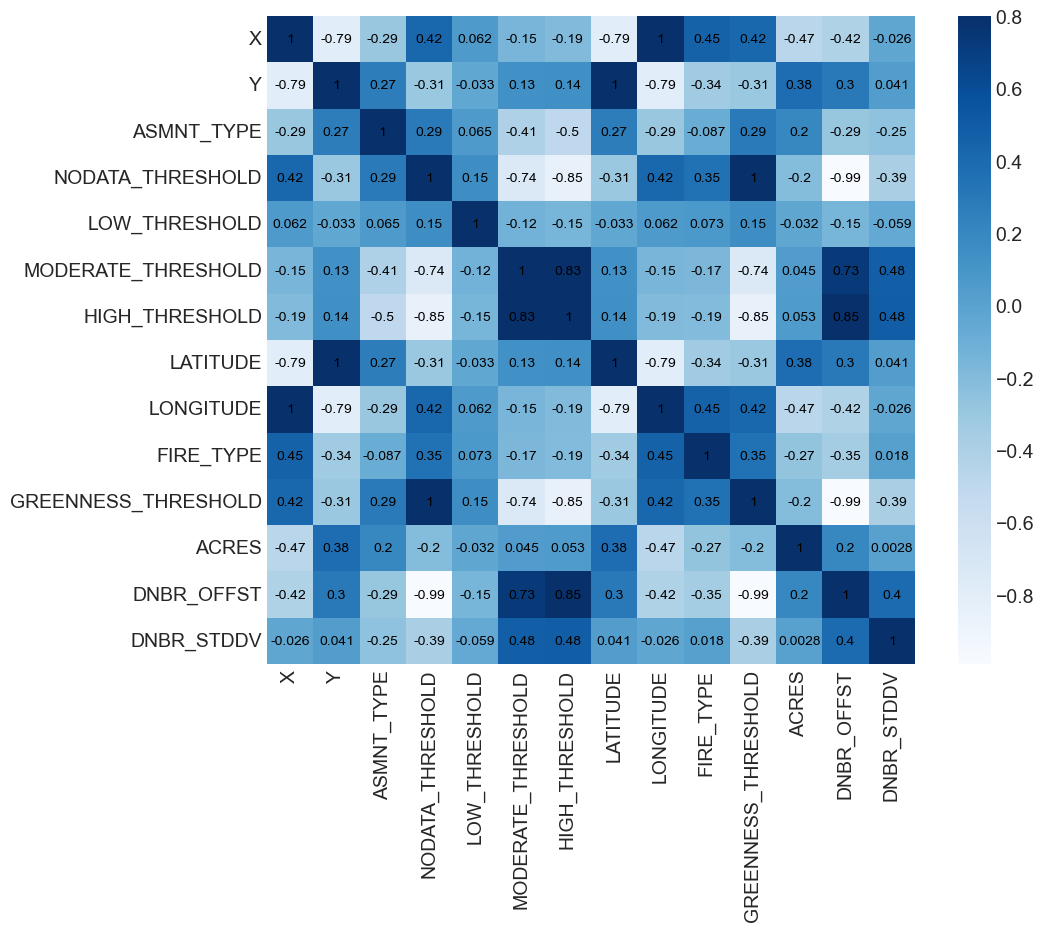

In [28]:
corr = df.corr()
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, vmax = .8, square = True, annot_kws = {"size": 10, "color": "black"}, cmap = 'Blues', annot = True)

### 5. Numerical Data

In [29]:
calc_ACRES = stat.mean(fire_original['ACRES'])
print("ACRES :", calc_ACRES)

ACRES : 6962.795042833441


In [30]:
(df.corr()**2)["ACRES"].sort_values(ascending = False)[:28]

ACRES                  1.000000
X                      0.224026
LONGITUDE              0.224003
Y                      0.141517
LATITUDE               0.141517
FIRE_TYPE              0.072647
NODATA_THRESHOLD       0.041924
GREENNESS_THRESHOLD    0.041898
DNBR_OFFST             0.041530
ASMNT_TYPE             0.041309
HIGH_THRESHOLD         0.002759
MODERATE_THRESHOLD     0.002027
LOW_THRESHOLD          0.001010
DNBR_STDDV             0.000008
Name: ACRES, dtype: float64

#### Checking Multicolinearity with ACRES

In [31]:
corr_data_with_ACRES = (df.corr()**2)["ACRES"] # Leaving out ACRES

high_corr_list = (corr_data_with_ACRES[abs(corr_data_with_ACRES) >= 0.005].sort_values(ascending = False))
low_corr_list = (corr_data_with_ACRES[(abs(corr_data_with_ACRES) < 0.005)].sort_values(ascending = False))

print(f"{len(high_corr_list)} high correlated values with ACRES:\n{high_corr_list}\n")
print(f"{len(low_corr_list)} low correlated values with ACRES:\n{low_corr_list}\n")

10 high correlated values with ACRES:
ACRES                  1.000000
X                      0.224026
LONGITUDE              0.224003
Y                      0.141517
LATITUDE               0.141517
FIRE_TYPE              0.072647
NODATA_THRESHOLD       0.041924
GREENNESS_THRESHOLD    0.041898
DNBR_OFFST             0.041530
ASMNT_TYPE             0.041309
Name: ACRES, dtype: float64

4 low correlated values with ACRES:
HIGH_THRESHOLD        0.002759
MODERATE_THRESHOLD    0.002027
LOW_THRESHOLD         0.001010
DNBR_STDDV            0.000008
Name: ACRES, dtype: float64



In [32]:
df[['IG_DATE']] = df[['IG_DATE']].astype('int64')

In [33]:
pd.DataFrame(df.ACRES).astype(int)

,ACRES
0,7
1,6
2,8
3,7
4,7
...,...
29528,8
29529,7
29530,9
29531,7


### 6. Spliting Data

In [34]:
df_y = pd.DataFrame(df.ACRES).astype(int)
df_x = df.drop('ACRES', axis=1, inplace=False)

In [35]:
#splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size = 0.2, random_state = 42)

print(f'X_train: {X_train.shape}')
print(f'y_train: {y_train.shape}\n')
print(f'X_test: {X_test.shape}')
print(f'y_test: {y_test.shape}')

X_train: (23626, 14)
y_train: (23626, 1)

X_test: (5907, 14)
y_test: (5907, 1)


### 7. MODELS

#### 7.1 Linear Regression

In [36]:
model_LR = LinearRegression()
scores_LR = cross_val_score(model_LR, X_train, y_train, cv = 5)

print("Mean scores (Linear Model):\n", np.mean(scores_LR))
print("Standard deviation of scores (Linear Model):\n", np.std(scores_LR))

scores_LR_mse = cross_val_score(model_LR, X_train, y_train, cv = 5, scoring = 'neg_mean_squared_error') * -1 

print(f"MSE scores (Linear Model): {scores_LR_mse}")
print("Mean MSE scores:", scores_LR_mse.mean())

Mean scores (Linear Model):
 0.09394797039197475
Standard deviation of scores (Linear Model):
 0.005222584727783356
MSE scores (Linear Model): [1.13803313 1.21395978 1.21227497 1.17763535 1.14855771]
Mean MSE scores: 1.1780921895039482


In [37]:
model_LR.fit(X_train, y_train)
y_pred_LR = model_LR.predict(X_test)


print(f"R² Score: {r2_score(y_test, y_pred_LR)}")
print(f"RMSE: {mean_squared_error(y_test, y_pred_LR, squared = False)}")

R² Score: 0.09818432901451968
RMSE: 1.0969273461155506


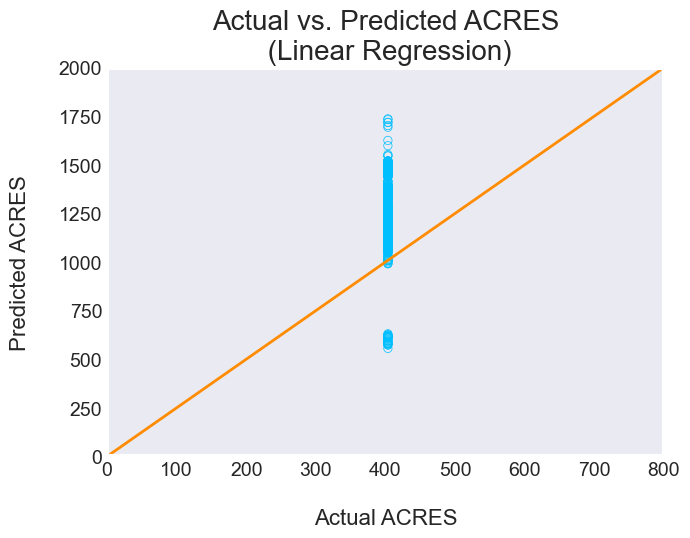

In [38]:
plt.figure()
plt.title("Actual vs. Predicted ACRES\n (Linear Regression)", fontsize = 20)
plt.scatter(np.exp(y_test), np.exp(y_pred_LR),
            color = "deepskyblue", marker = "o", facecolors = "none")
plt.plot([0, 800], [0, 2000], "darkorange", lw = 2)
plt.xlim(0, 800)
plt.ylim(0, 2000)
plt.xlabel("\nActual ACRES", fontsize=16)
plt.ylabel("Predicted ACRES\n", fontsize=16)
plt.show()

#### 7.2 Ridge Regression

In [39]:
model_Ridge = Ridge(alpha = 0.001)

scores_ridge = cross_val_score(model_Ridge, X_train, y_train, cv = 5)
scores_ridge_mse = cross_val_score(model_Ridge, X_train, y_train, cv = 5, scoring = 'neg_mean_squared_error') * -1 


print(f"Mean scores (Ridge Model): {np.mean(scores_ridge)}")
print(f"Standard deviation of scores (Ridge Model): {np.std(scores_ridge)}\n")

print(f"MSE scores (Ridge Model): {scores_ridge_mse}")
print(f"Mean MSE scores: {scores_ridge_mse.mean()}")

Mean scores (Ridge Model): 0.19377389804326778
Standard deviation of scores (Ridge Model): 0.06996855849753823

MSE scores (Ridge Model): [0.98361864 1.27683987 1.00233642 0.99958968 0.98690887]
Mean MSE scores: 1.0498586960301162


In [40]:
model_Ridge.fit(X_train, y_train)
y_pred_ridge = model_Ridge.predict(X_test)

print(f"R² Score: {r2_score(y_test, y_pred_ridge)}")
print("RMSE: ", (np.sqrt(mean_squared_error(y_test, y_pred_ridge))))

R² Score: 0.24823597019663268
RMSE:  1.0015202745677785


#### 7.2.1 Hyperparameter tuning Ridge

In [41]:
alphas = np.linspace(0, 10, 100).tolist()

tuned_parameters = {"alpha": alphas}
ridge_cv = GridSearchCV(Ridge(), tuned_parameters, cv = 10, n_jobs = -1, verbose = 1)

ridge_cv.fit(X_train, y_train)


print(f"Best hyperparameters: {ridge_cv.best_params_}")
print(f"Best R² (train): {ridge_cv.best_score_}")

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best hyperparameters: {'alpha': 10.0}
Best R² (train): 0.2332272576567725


In [42]:
model_Ridge = Lasso(alpha = 10.0)
scores_Ridge = cross_val_score(model_Ridge, X_train, y_train, cv = 10)
# scores_Lasso_mse = cross_val_score(model_Ridge, X_train, y_train, cv = 10, scoring = 'neg_mean_squared_error') * -1 


model_Ridge.fit(X_train, y_train)
y_pred_ridge = model_Ridge.predict(X_test)

print(f"R² Score: {r2_score(y_test, y_pred_ridge)}")
print("RMSE: ", (np.sqrt(mean_squared_error(y_test, y_pred_ridge))))

R² Score: 0.09827453633566152
RMSE:  1.0968724827132135


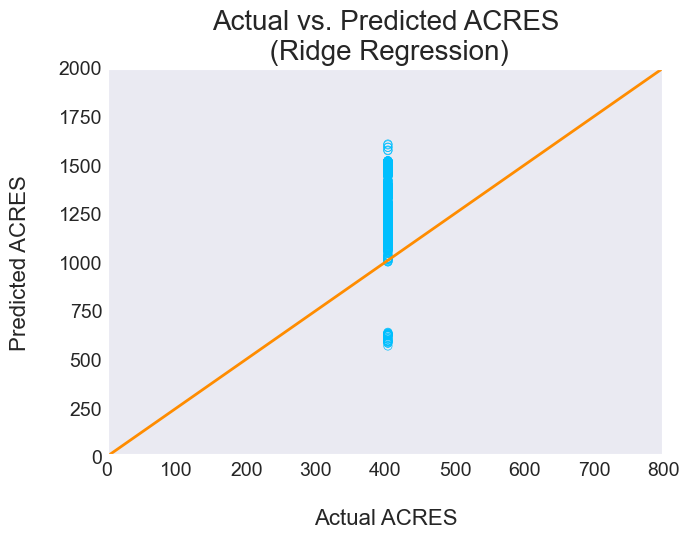

In [43]:
plt.figure()
plt.title("Actual vs. Predicted ACRES\n (Ridge Regression)", fontsize = 20)
plt.scatter(np.exp(y_test), np.exp(y_pred_ridge),
            color = "deepskyblue", marker = "o", facecolors = "none")
plt.plot([0, 800], [0, 2000], "darkorange", lw = 2)
plt.xlim(0, 800)
plt.ylim(0, 2000)
plt.xlabel("\nActual ACRES", fontsize=16)
plt.ylabel("Predicted ACRES\n", fontsize=16)
plt.show()

#### 7.3 Lasso Regression

In [44]:
model_Lasso = Lasso(alpha = 0.001)
scores_Lasso = cross_val_score(model_Lasso, X_train, y_train, cv = 5)
scores_Lasso_mse = cross_val_score(model_Lasso, X_train, y_train, cv = 5, scoring = 'neg_mean_squared_error') * -1 


print(f"Mean scores (Lasso Model): {np.mean(scores_Lasso)}")
print(f"Standard deviation of scores (Lasso Model): {np.std(scores_Lasso)}\n")

print(f"MSE scores (Lasso Model): {scores_Lasso_mse}")
print(f"Mean MSE scores: {scores_Lasso_mse.mean()}")

Mean scores (Lasso Model): 0.23257145843659935
Standard deviation of scores (Lasso Model): 0.013382939662059326

MSE scores (Lasso Model): [0.98201243 1.01880365 1.00155494 1.00010547 0.98475117]
Mean MSE scores: 0.9974455323988913


In [45]:
model_Lasso.fit(X_train, y_train)
y_pred_lasso = model_Lasso.predict(X_test)

print(f"R² Score: {r2_score(y_test, y_pred_lasso)}")
print("RMSE: ", (np.sqrt(mean_squared_error(y_test, y_pred_lasso))))

R² Score: 0.2472447686923499
RMSE:  1.0021803097365325


#### 7.3.1 Hyperparameter tunning Lasso

In [46]:
alphas = np.linspace(0, 10, 100).tolist()

tuned_parameters = {"alpha": alphas}
lasso_cv = GridSearchCV(Lasso(), tuned_parameters, cv = 10, n_jobs = -1, verbose = 1)

lasso_cv.fit(X_train, y_train)


print(f"Best hyperparameters: {lasso_cv.best_params_}")
print(f"Best R² (train): {lasso_cv.best_score_}")

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best hyperparameters: {'alpha': 0.0}
Best R² (train): 0.23285080167203626


In [47]:
model_Lasso = Lasso(alpha = 0.0)
scores_Lasso = cross_val_score(model_Lasso, X_train, y_train, cv = 10)
scores_Lasso_mse = cross_val_score(model_Lasso, X_train, y_train, cv = 10, scoring = 'neg_mean_squared_error') * -1 


model_Lasso.fit(X_train, y_train)
y_pred_lasso = model_Lasso.predict(X_test)

print(f"R² Score: {r2_score(y_test, y_pred_lasso)}")
print("RMSE: ", (np.sqrt(mean_squared_error(y_test, y_pred_lasso))))

R² Score: 0.24723827970978485
RMSE:  1.0021846292791088


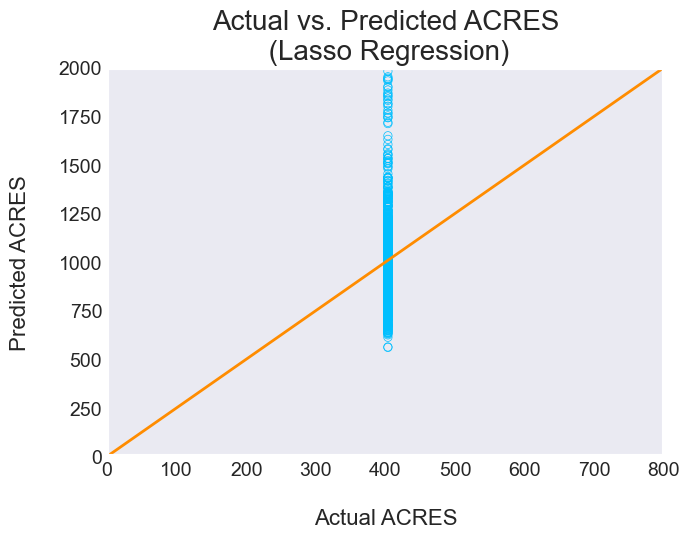

In [48]:
plt.figure()
plt.title("Actual vs. Predicted ACRES\n (Lasso Regression)", fontsize = 20)
plt.scatter(np.exp(y_test), np.exp(y_pred_lasso),
            color = "deepskyblue", marker = "o", facecolors = "none")
plt.plot([0, 800], [0, 2000], "darkorange", lw = 2)
plt.xlim(0, 800)
plt.ylim(0, 2000)
plt.xlabel("\nActual ACRES", fontsize=16)
plt.ylabel("Predicted ACRES\n", fontsize=16)
plt.show()

#### 7.4 Decision Tree Regressor

In [49]:
model_Tree = DecisionTreeRegressor()

scores_Tree = cross_val_score(model_Tree, X_train, y_train, cv = 5)
scores_Tree_mse = cross_val_score(model_Tree, X_train, y_train, cv = 5, scoring = 'neg_mean_squared_error') * -1 


print(f"Mean scores (Decision Tree Model): {np.mean(scores_Tree)}")
print(f"Standard deviation of scores (Decision Tree Model): {np.std(scores_Tree)}\n")

print(f"MSE scores (Decision Tree Model): {scores_Tree_mse}")
print(f"Mean MSE scores: {scores_Tree_mse.mean()}")

Mean scores (Decision Tree Model): -0.2926897609354696
Standard deviation of scores (Decision Tree Model): 0.034890340542558095

MSE scores (Decision Tree Model): [1.65531105 1.7437037  1.65650794 1.71534392 1.61862434]
Mean MSE scores: 1.6778981878922632


In [50]:
model_Tree.fit(X_train, y_train)
y_pred_Tree = model_Tree.predict(X_test)

print(f"R² Score: {r2_score(y_test, y_pred_Tree)}")
print("RMSE: ", (np.sqrt(mean_squared_error(y_test, y_pred_Tree))))

R² Score: -0.25814761344694204
RMSE:  1.2956412714886125


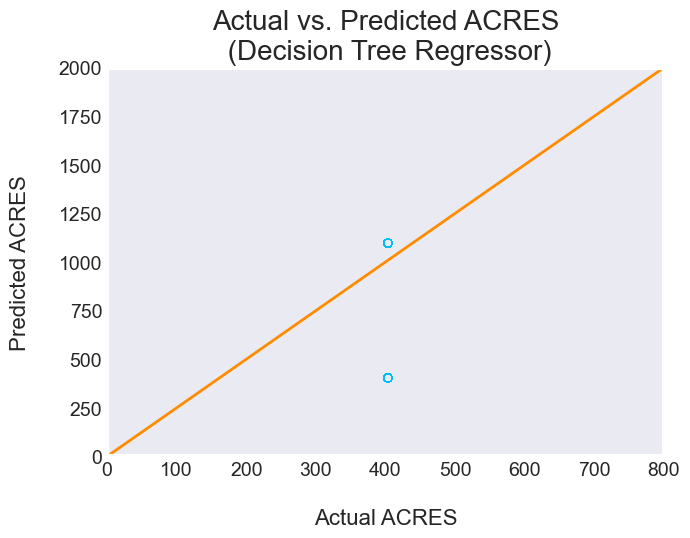

In [51]:
plt.figure()
plt.title("Actual vs. Predicted ACRES\n (Decision Tree Regressor)", fontsize = 20)
plt.scatter(np.exp(y_test), np.exp(y_pred_Tree),
            color = "deepskyblue", marker = "o", facecolors = "none")
plt.plot([0, 800], [0, 2000], "darkorange", lw = 2)
plt.xlim(0, 800)
plt.ylim(0, 2000)
plt.xlabel("\nActual ACRES", fontsize=16)
plt.ylabel("Predicted ACRES\n", fontsize=16)
plt.show()

#### 7.5 Random Forest Regressor

In [52]:
model_Random = RandomForestRegressor()

scores_Random = cross_val_score(model_Random, X_train, y_train, cv = 5)
scores_Random_mse = cross_val_score(model_Random, X_train, y_train, cv = 5, scoring = 'neg_mean_squared_error') * -1 


print(f"Mean scores (Random Forest Model): {np.mean(scores_Random)}")
print(f"Standard deviation of scores (Random Forest Model): {np.std(scores_Random)}\n")

print(f"MSE scores (Random Forest Model): {scores_Random_mse}")
print(f"Mean MSE scores: {scores_Random_mse.mean()}")

Mean scores (Random Forest Model): 0.3341415464886853
Standard deviation of scores (Random Forest Model): 0.014004950398599818

MSE scores (Random Forest Model): [0.85684192 0.88151067 0.8686066  0.89185892 0.85101981]
Mean MSE scores: 0.8699675834109183


In [53]:
model_Random.fit(X_train, y_train)
y_pred_Random = model_Random.predict(X_test)

print(f"R² Score: {r2_score(y_test, y_pred_Random)}")
print("RMSE: ", (np.sqrt(mean_squared_error(y_test, y_pred_Random))))
# 0.5 R-squared better, RMSE near zero better

R² Score: 0.33618081524721544
RMSE:  0.9411175545945036


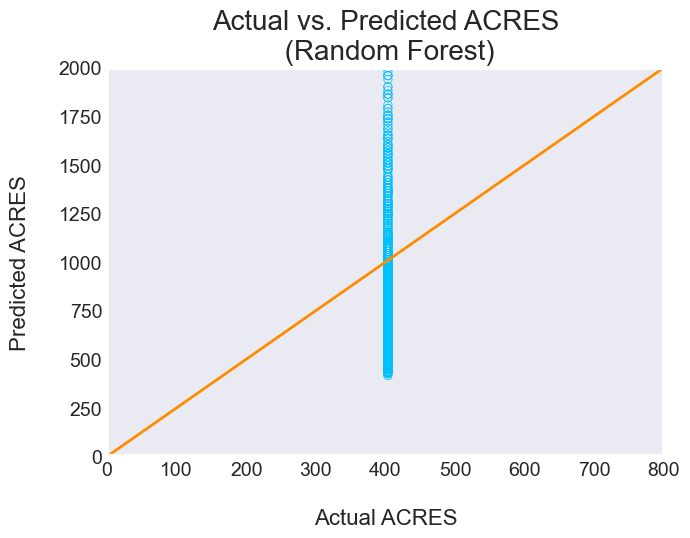

In [54]:
plt.figure()
plt.title("Actual vs. Predicted ACRES\n (Random Forest)", fontsize = 20)
plt.scatter(np.exp(y_test), np.exp(y_pred_Random),
            color = "deepskyblue", marker = "o", facecolors = "none")
plt.plot([0, 800], [0, 2000], "darkorange", lw = 2)
plt.xlim(0, 800)
plt.ylim(0, 2000)
plt.xlabel("\nActual ACRES", fontsize=16)
plt.ylabel("Predicted ACRES\n", fontsize=16)
plt.show()

#### 7.6 XGBoost Regressor

In [55]:
model_xgb_regressor = XGBRegressor()

scores_xgb_regressor = cross_val_score(model_xgb_regressor, X_train, y_train, cv = 5)
scores_xgb_regressor_mse = cross_val_score(model_xgb_regressor, X_train, y_train, cv = 5, scoring = 'neg_mean_squared_error') * -1 


print(f"Mean scores (XGB Model): {np.mean(scores_xgb_regressor)}")
print(f"Standard deviation of scores (XGB Model): {np.std(scores_xgb_regressor)}\n")

print(f"MSE scores (XGB Model): {scores_xgb_regressor_mse}")
print(f"Mean MSE scores: {scores_xgb_regressor_mse.mean()}")

Mean scores (XGB Model): 0.30944597529156626
Standard deviation of scores (XGB Model): 0.013153612020463702

MSE scores (XGB Model): [0.87845991 0.92694602 0.88960941 0.90205329 0.89079544]
Mean MSE scores: 0.897572813666662


In [56]:
model_xgb_regressor.fit(X_train, y_train)
y_pred_xgb_regressor = model_xgb_regressor.predict(X_test)

print(f"R² Score: {r2_score(y_test, y_pred_xgb_regressor)}")
print("RMSE: ", (np.sqrt(mean_squared_error(y_test, y_pred_xgb_regressor))))

R² Score: 0.3193538274235168
RMSE:  0.9529709849738751


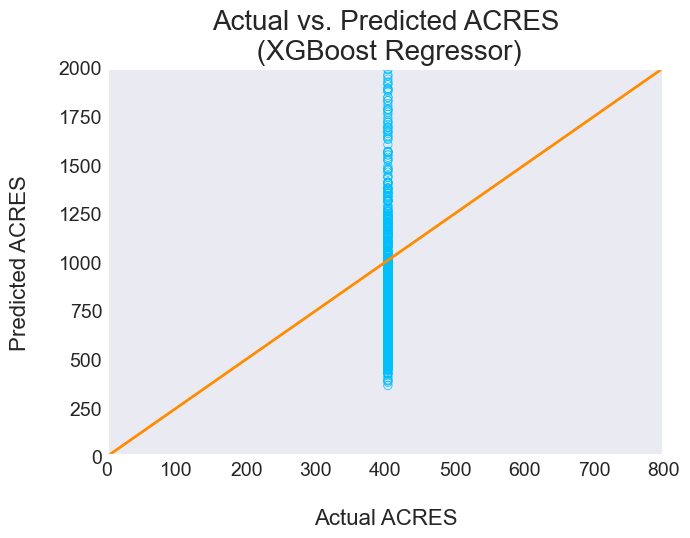

In [57]:
plt.figure()
plt.title("Actual vs. Predicted ACRES\n (XGBoost Regressor)", fontsize = 20)
plt.scatter(np.exp(y_test), np.exp(y_pred_xgb_regressor),
            color = "deepskyblue", marker = "o", facecolors = "none")
plt.plot([0, 800], [0, 2000], "darkorange", lw = 2)
plt.xlim(0, 800)
plt.ylim(0, 2000)
plt.xlabel("\nActual ACRES", fontsize=16)
plt.ylabel("Predicted ACRES\n", fontsize=16)
plt.show()

#### 7.7 Artificial Neural Network

In [58]:
# create ANN model
model_ANN = Sequential()

# Defining the Input layer and FIRST hidden layer, both are same!
model_ANN.add(Dense(units=29533, input_dim=14, kernel_initializer='normal', activation='relu'))

# Defining the Second layer of the model
# after the first layer we don't have to specify input_dim as keras configure it automatically
model_ANN.add(Dense(units=5, kernel_initializer='normal', activation='tanh'))

# The output neuron is a single fully connected node 
# Since we will be predicting a single number
model_ANN.add(Dense(1, kernel_initializer='normal'))

# Compiling the model
model_ANN.compile(loss='mean_squared_error', optimizer='adam')

# Fitting the ANN to the Training set
model_ANN.fit(X_train, y_train ,batch_size = 20, epochs = 50, verbose=1)

Epoch 1/50
1182/1182 [==============================] - 9s 7ms/step - loss: 22.9596
Epoch 2/50
1182/1182 [==============================] - 9s 8ms/step - loss: 2.2937
Epoch 3/50
1182/1182 [==============================] - 9s 8ms/step - loss: 1.3045
Epoch 4/50
1182/1182 [==============================] - 9s 7ms/step - loss: 1.3009
Epoch 5/50
1182/1182 [==============================] - 9s 8ms/step - loss: 1.3008
Epoch 6/50
1182/1182 [==============================] - 9s 8ms/step - loss: 1.3015
Epoch 7/50
1182/1182 [==============================] - 9s 7ms/step - loss: 1.3016
Epoch 8/50
1182/1182 [==============================] - 9s 8ms/step - loss: 1.3015
Epoch 9/50
1182/1182 [==============================] - 9s 8ms/step - loss: 1.3015
Epoch 10/50
1182/1182 [==============================] - 9s 8ms/step - loss: 1.3018
Epoch 11/50
1182/1182 [==============================] - 10s 9ms/step - loss: 1.3016
Epoch 12/50
1182/1182 [==============================] - 9s 8ms/step - loss: 1.3017

In [60]:
# Fitting the ANN to the Training set
model_ANN.fit(X_train, y_train, batch_size = 15, epochs = 5, verbose=0)

# Generating Predictions on testing data
y_pred_ANN = model_ANN.predict(X_test)

print(f"Mean MSE scores: {(mean_squared_error(y_test, y_pred_ANN))}")

print(f"R² Score: {r2_score(y_test, y_pred_ANN)}")
print("RMSE: ", (np.sqrt(mean_squared_error(y_test, y_pred_ANN))))

185/185 [==============================] - 2s 6ms/step
Mean MSE scores: 1.3349818911137892
R² Score: -0.0005468418445264689
RMSE:  1.155414164321084


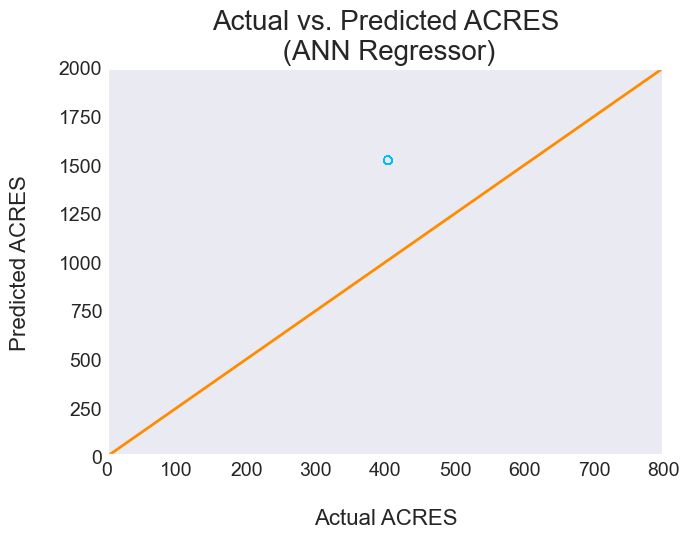

In [61]:
plt.figure()
plt.title("Actual vs. Predicted ACRES\n (ANN Regressor)", fontsize = 20)
plt.scatter(np.exp(y_test), np.exp(y_pred_ANN),
            color = "deepskyblue", marker = "o", facecolors = "none")
plt.plot([0, 800], [0, 2000], "darkorange", lw = 2)
plt.xlim(0, 800)
plt.ylim(0, 2000)
plt.xlabel("\nActual ACRES", fontsize=16)
plt.ylabel("Predicted ACRES\n", fontsize=16)
plt.show()